# Preparing the corpus

In [2]:
# hide jupyter warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [1]:
import pyLDAvis
import pyLDAvis.gensim

from tqdm import tqdm_notebook as tqdm

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

/anaconda/envs/pfe-env/lib/python3.8/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [5]:
df = pd.read_json('../input/iphone-12-tweets-fr.json', lines=True)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# remove duplicates 
# 840 tweets had been droped

df = df[df['lang'] == 'fr']
df = df.sort_values("content") 
  
# dropping ALL duplicte values 
df = df.drop_duplicates(subset ="content", keep = 'first')

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
# selectionner que les tweets qui répondent au requetes de l'utilisateur

data = df['content']

with open('../input/keywords.txt', encoding='utf-8') as f:
    keywords = f.read().splitlines()

data = data[data.str.contains('|'.join(keywords), case=False)]

# supprimer les tweets inutiles (publicité, concours ..)

with open('../input/ads_words.txt', encoding='utf-8') as f:
    ads_words = f.read().splitlines()

data = data[~data.str.contains('|'.join(ads_words), case=False)]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
with open('../input/keywords.txt', encoding='utf-8') as f:
    keywords = f.read().splitlines()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
import re
import json
from html.parser import HTMLParser
from io import StringIO

import demoji
demoji.download_codes()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


... OK (Got response in 0.39 seconds)
Writing emoji data to /home/azureuser/.demoji/codes.json ...
... OK


In [10]:
class MLStripper(HTMLParser):
        def __init__(self):
            super().__init__()
            self.reset()
            self.strict = False
            self.convert_charrefs= True
            self.text = StringIO()
        def handle_data(self, d):
            self.text.write(d)
        def get_data(self):
            return self.text.getvalue()
        
def html_free_text(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def emoji_free_text(text):
    return demoji.replace(text, '').strip()

def url_free_text(text):
    text = re.sub(r'(?:\@|https?\://)\S+', '', text)
    return text
    
with open('../input/abrivot_fr.json', encoding='utf-8') as f:
        abrivot = json.load(f)   
        
def abrivot_free_text(text):
    words = text.lower().split()
    text_out = [abrivot[word] if word in abrivot else word for word in words]
    return ' '.join(text_out)

def punct_free_text(text):
    text_out = simple_preprocess(text, deacc=True, min_len=3)
    #return ' '.join(text_out)
    return text_out

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Pre-Process the data

In [11]:
%%time

data_free_html = data.apply(html_free_text)
data_free_emoji = data_free_html.apply(emoji_free_text)
data_free_url = data_free_emoji.apply(url_free_text)
data_free_abrivot = data_free_url.apply(abrivot_free_text)
data_free_punct = data_free_url.apply(punct_free_text)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 13.6 s, sys: 14.7 ms, total: 13.6 s
Wall time: 13.6 s


In [12]:
# Build the bigram and trigrams

data = list(data_free_punct)

bigram = gensim.models.Phrases(data, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# define a preprocessing function

# only need tagger, no need for parser and named entity recognizer, for faster implementation
nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])

# get stopwords
# ask the user to specify the brand name to be added to the stopwords
# or implement it manually
with open('../input/fr_stopwords.txt', encoding='utf-8') as f:
    fr_stopwords = f.read().splitlines()
stop_words = nlp.Defaults.stop_words.union(fr_stopwords)


# final preprocesser
def process_words(texts, stop_words=stop_words, allowed_tags=['NOUN']):
    
    """Convert a document into a list of lowercase tokens, build bigrams-trigrams, implement lemmatization"""
    
    # remove stopwords, short tokens and letter accents 
    #texts = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts]
    texts = [[word for word in doc if word not in stop_words] for doc in texts]

    
    # bi-gram and tri-gram implementation
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    texts_out = []
    
    # implement lemmatization and filter out unwanted part of speech tags
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_tags])
    
    # remove stopwords and short tokens again after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc), deacc=True, min_len=3) if word not in stop_words] for doc in texts_out]    
    
    return texts_out

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
%%time

data_ready = process_words(data)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 1min 10s, sys: 79.4 ms, total: 1min 10s
Wall time: 1min 10s


In [15]:
# create the Dictionary

id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total Vocabulary Size: 5287


In [16]:
# create the corpus
corpus = [id2word.doc2bow(text) for text in data_ready]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
dict_corpus = {}

for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if id2word[idx] in dict_corpus:
            dict_corpus[id2word[idx]] += freq
        else:
            dict_corpus[id2word[idx]] = freq

dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


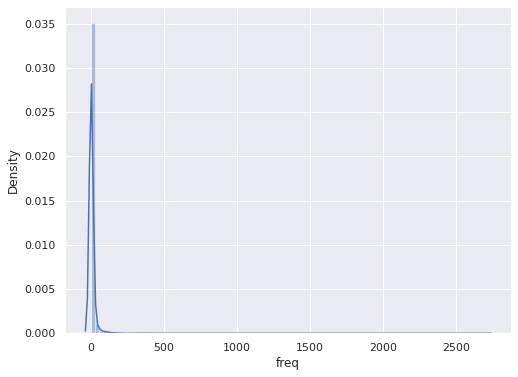

In [18]:
plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);

In [19]:
dict_df.sort_values('freq', ascending=False).head(10)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,freq
max,2702
iphone,1720
pro,1652
prix,1580
chargeur,1562
apple,1458
photo,1235
batterie,1023
mini,935
euro,431


In [20]:
# remove the 3 top words
threshold = dict_df.sort_values('freq', ascending=False).iloc[9].values[0]
extension = dict_df[dict_df.freq>threshold].index.tolist()

extension = [word for word in extension if word not in keywords]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# ask the user to specify the brand name to be added to the stopwords
# or implement it manually
# tweek the extension list to get words with typo
extension.append('appl')
extension.append('iphon')

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# add high frequency words to stop words list
stop_words.update(extension)
# rerun the process_words function
data_ready = process_words(data)
# recreate Dictionary
id2word = corpora.Dictionary(data_ready)
print('Total Vocabulary Size:', len(id2word))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total Vocabulary Size: 5091


In [23]:
# Filter extreme words
# Filter out words that occur less than 20 documents, or more than
# 90% of the documents.

id2word.filter_extremes(no_below=20, no_above=0.9)
print('Total Vocabulary Size:', len(id2word))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total Vocabulary Size: 352


In [24]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Finding the optimal number of topics

In [25]:
from gensim.models import LdaMulticore, CoherenceModel

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
%%time

num_topics = list(range(1, 50, 1)[1:])
num_keywords = 20

LDA_models = {}
LDA_topics = {}
for i in tqdm(num_topics):
    LDA_models[i] = LdaMulticore(corpus=corpus,
                                id2word=id2word,
                                num_topics=i,
                                chunksize=2000,
                                passes=25,
                                iterations=70,
                                decay=0.5,
                                random_state=100
                                #per_word_topics=True,
                                #minimum_phi_value=0.02,
                                #minimum_probability=0.4,
                                #eval_every=1
                                )

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 23min 58s, sys: 27.6 s, total: 24min 26s
Wall time: 24min 17s


In [62]:
# Now create a function to derive the Jaccard similarity of two topics:

def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
# Use the above to derive the mean stability across topics by considering the next topic:

LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
# calculate the coherence value with the built in gensim

coherences = [CoherenceModel(model=LDA_models[i], texts=data_ready,
                             dictionary=id2word, coherence='c_v', topn=num_keywords).get_coherence() for i in num_topics[:-1]]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
# From here derive the ideal number of topics roughly through the difference between the coherence and stability per number of topics:


coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(len(num_topics) - 1)[:-1]]
#coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


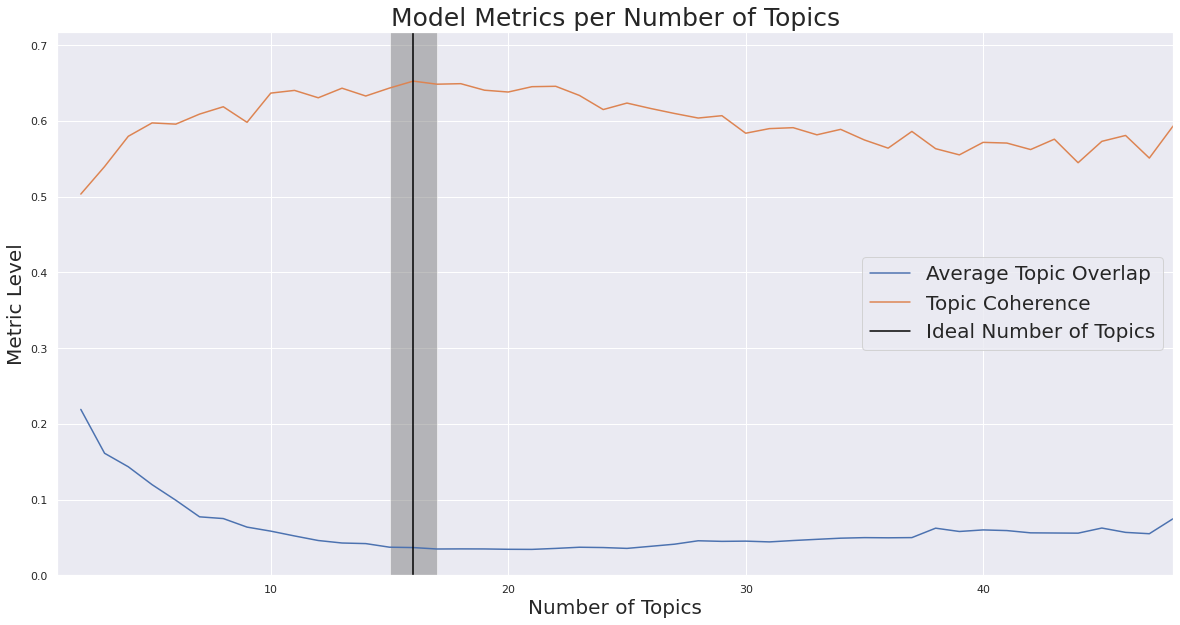

In [66]:
# Finally graph these metrics across the topic numbers:

plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()   

Your ideal number of topics will maximize coherence and minimize the topic overlap based on Jaccard similarity.

In [67]:
print('Ideal number of topics: ', ideal_topic_num)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Ideal number of topics:  16


# Building the LDA Model

Download the LDA mallet from `!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip`  
Extract the model `!unzip mallet-2.0.8.zip`

In [68]:
ldamodel = LDA_models[ideal_topic_num]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
# Compute Coherence Score
coherence_model_ldamodel = CoherenceModel(model=ldamodel, texts=data_ready, dictionary=id2word, coherence='c_v', topn=num_keywords)
coherence_ldamodel = coherence_model_ldamodel.get_coherence()
print('Coherence Score: ', coherence_ldamodel)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score:  0.6525885693420983


In [70]:
from pprint import pprint
# display topics
pprint(ldamodel.show_topics(num_topics = ideal_topic_num, formatted=True))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.237*"taille" + 0.080*"recu" + 0.062*"reseau" + 0.057*"demande" + '
  '0.050*"dommage" + 0.050*"tech" + 0.047*"cas" + 0.045*"choisir" + '
  '0.034*"impression" + 0.034*"reduction"'),
 (1,
  '0.400*"prix" + 0.315*"batterie" + 0.130*"protection" + 0.052*"coque" + '
  '0.024*"change" + 0.018*"vien" + 0.014*"baisse" + 0.012*"iphonote" + '
  '0.008*"objectif" + 0.008*"fabrication"'),
 (2,
  '0.496*"chargeur" + 0.115*"charge" + 0.113*"magsafe" + 0.043*"part" + '
  '0.040*"prise" + 0.035*"livre" + 0.022*"cuir" + 0.022*"base" + '
  '0.021*"raison" + 0.013*"recharge"'),
 (3,
  '0.138*"ecouteur" + 0.133*"chargeur" + 0.077*"niveau" + 0.075*"version" + '
  '0.069*"cote" + 0.068*"lien" + 0.062*"annonce" + 0.058*"face" + '
  '0.034*"absence" + 0.032*"fil"'),
 (4,
  '0.256*"euro" + 0.164*"telephone" + 0.054*"video" + 0.054*"meilleur" + '
  '0.053*"vente" + 0.050*"technologie" + 0.046*"lance" + 0.044*"probleme" + '
  '0.033*"minute" + 0.024*"carte_sim"'),
 (5,
  '0.092*"compte" + 0.079*"debal

In [71]:
# save the model for later

import pickle
pickle.dump(ldamodel, open("../saved models/ldamodel.pkl", "wb"))

# load the model
#ldamallet = pickle.load(open("../saved models/ldamallet.pkl", "rb"))

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
# distribution of topics for each document

tm_results = ldamodel[corpus]

# We can get the most dominant topic of each document as below:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
# get most probable words for the given topicis

topics = [[(term, round(wt, 3)) for term, wt in ldamodel.show_topic(n, topn=20)] for n in range(0, ldamodel.num_topics)]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
# create a dataframe for term-topic matrix:

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics],
                         columns = ['Term'+str(i) for i in range(1, 21)],
                         index=['Topic '+str(t) for t in range(1, ldamodel.num_topics+1)]).T
topics_df.head()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16
Term1,taille,prix,chargeur,ecouteur,euro,compte,photo,homepod,appareil,smartphone,ecran,couleur,test_bluetooth,autonomie,boite,difference
Term2,recu,batterie,charge,chargeur,telephone,deballage,vie,keynote,envie,question,offre,suite,site,oled,bientot,pouce
Term3,reseau,protection,magsafe,niveau,video,soir,rapport,devoile,argent,test,mise,cadeau,succe,heure,voi,prix
Term4,demande,coque,part,version,meilleur,place,gamme,sortie,fin,igeneration,lieu,reparation,promo,utilisation,qualite,marche
Term5,dommage,change,prise,cote,vente,demontage,mode,samsung,performance,protection,studio,stockage,plutot,temps,penurie,peine


In [75]:
# another option

# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics],
                         columns = ['Terms per Topic'],
                         index=['Topic'+str(t) for t in range(1, ldamodel.num_topics+1)] )
topics_df

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Terms per Topic
Topic1,"taille, recu, reseau, demande, dommage, tech, cas, choisir, impression, reduction, plaisir, promotion, vendre, serie, travail, partie, air, dispo, lot, enfant"
Topic2,"prix, batterie, protection, coque, change, vien, baisse, iphonote, objectif, fabrication, eau, belgium, condition, coque_etui, equipe, matin, reduction, stockage, annonce, internet"
Topic3,"chargeur, charge, magsafe, part, prise, livre, cuir, base, raison, recharge, ecologie, jaune, induction, exemple, limite, serie, etui, support, mode, supporte"
Topic4,"ecouteur, chargeur, niveau, version, cote, lien, annonce, face, absence, fil, generation, coque_etui, pacemaker, spigen, presentation, boite, hesite, bord, jailbreak, actualite"
Topic5,"euro, telephone, video, meilleur, vente, technologie, lance, probleme, minute, carte_sim, dxomark, sort, publication, presse_citron, plan, paie, reduction, coute, airpod, minimum"
Topic6,"compte, deballage, soir, place, demontage, recharge, bloc, oeil, vue, gosse, code, cherche, affaire, parent, valeur, capteur_lidar, ipad, tombe, arrivee, jeu"
Topic7,"photo, vie, rapport, gamme, mode, capteur, janvier, fonction, plan, perso, objectif, force, ligne, casse, free, innovation, marque, amelioration, communication, pratique"
Topic8,"homepod, keynote, devoile, sortie, samsung, point, voiture, octobre, avis, blague, modele, comprend, rumeur, commander, grace, pigeon, dollar, heure, support, date_sortie"
Topic9,"appareil, envie, argent, fin, performance, fonds, article, balle, femme, gnt, compact, million, vitesse, silicone, espere, note, appel, accord, achat, inclu"
Topic10,"smartphone, question, test, igeneration, protection, besoin, idee, remise, super, vena, produit, coque, production, main, moche, coloris, monde, connexion, vie, pays"


/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


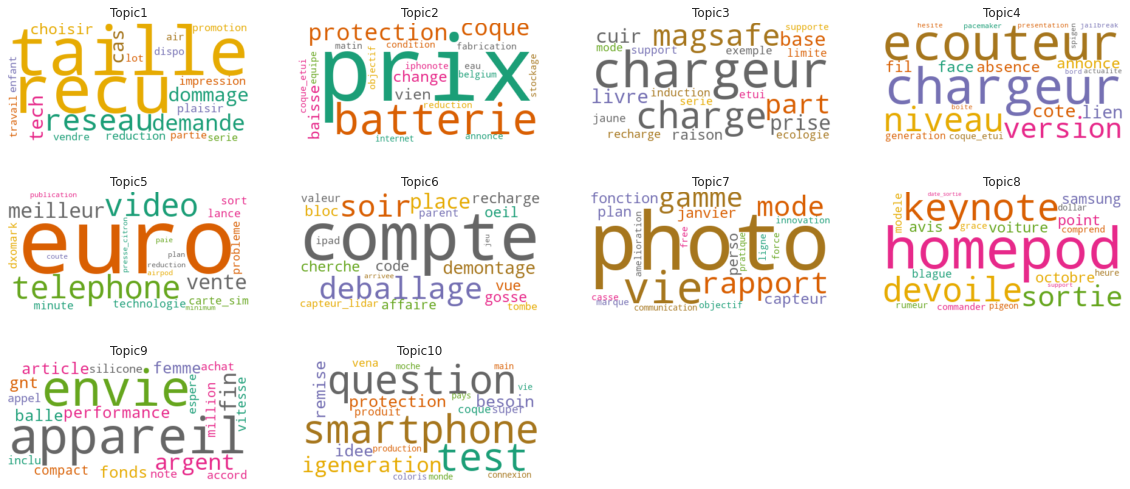

In [76]:
# worldcloud

# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(10):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [77]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, id2word)
vis

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.244727 -0.276672  1       1        9.499019
2     -0.322116 -0.184466  2       1        9.044069
6      0.033760  0.027281  3       1        7.434032
4     -0.003919  0.106749  4       1        6.676506
3     -0.313187 -0.173694  5       1        6.299732
7     -0.011043  0.102885  6       1        6.232931
9      0.155473 -0.112482  7       1        6.145020
13     0.029661  0.084619  8       1        6.087914
0     -0.007650  0.142605  9       1        6.026395
5     -0.027263  0.071580  10      1        5.415714
8     -0.003935  0.102054  11      1        5.409834
11     0.021295  0.125946  12      1        5.313801
10     0.033444  0.079515  13      1        5.263925
15     0.190985 -0.186023  14      1        5.258377
14    -0.041695 -0.018985  15      1        4.970946
12     0.021463  0.109087  16      1        4.921785, topic_info=          Term         Freq        Total Category  logprob  loglift
24   photo      1126.000000  1126.000000  Default  30.0000  30.0000
4    chargeur   1421.000000  1421.000000  Default  29.0000  29.0000
9    prix       1137.000000  1137.000000  Default  28.0000  28.0000
25   batterie   799.000000   799.000000   Default  27.0000  27.0000
17   euro       456.000000   456.000000   Default  26.0000  26.0000
..    ...              ...          ...       ...      ...      ...
216  phone      0.076004     15.654603    Topic16 -9.7565  -2.3162 
317  con        0.076004     15.830068    Topic16 -9.7565  -2.3274 
3    telephone  0.076004     293.304650   Topic16 -9.7565  -5.2467 
120  decembre   0.076004     24.693669    Topic16 -9.7565  -2.7720 
194  vien       0.076004     60.657466    Topic16 -9.7565  -3.6707 

[577 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
325   5      0.990253  absence
273   5      0.178366  accord 
273   11     0.789908  accord 
1     11     0.963916  achat  
203   12     0.979824  achete 
...   ..          ...    ...  
237   15     0.987360  voi    
195   6      0.988242  voiture
189   10     0.968603  vue    
324   15     0.943600  xiaomi 
98    8      0.984564  youtube

[433 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 7, 5, 4, 8, 10, 14, 1, 6, 9, 12, 11, 16, 15, 13])

# Dominant Topics for Each Document


In [78]:
# create a dataframe
corpus_topic_df = pd.DataFrame()

# get the Titles from the original dataframe
corpus_topic_df['Tweet_id'] = data_free_abrivot.index
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df.head()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Tweet_id,Dominant Topic,Contribution %,Topic Terms
0,19381,4,53.12,"ecouteur, chargeur, niveau, version, cote, lien, annonce, face, absence, fil, generation, coque_etui, pacemaker, spigen, presentation, boite, hesite, bord, jailbreak, actualite"
1,6029,5,26.56,"euro, telephone, video, meilleur, vente, technologie, lance, probleme, minute, carte_sim, dxomark, sort, publication, presse_citron, plan, paie, reduction, coute, airpod, minimum"
2,61267,3,53.12,"chargeur, charge, magsafe, part, prise, livre, cuir, base, raison, recharge, ecologie, jaune, induction, exemple, limite, serie, etui, support, mode, supporte"
3,61645,3,53.12,"chargeur, charge, magsafe, part, prise, livre, cuir, base, raison, recharge, ecologie, jaune, induction, exemple, limite, serie, etui, support, mode, supporte"
4,53240,7,53.12,"photo, vie, rapport, gamme, mode, capteur, janvier, fonction, plan, perso, objectif, force, ligne, casse, free, innovation, marque, amelioration, communication, pratique"


We can use pandas groupby function on “Dominant Topic” column and get the document counts for each topic and its percentage in the corpus with chaining agg function.

In [79]:
# Documents distribution ovec topics

dominant_topic_df = corpus_topic_df.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus), 2))

dominant_topic_df

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant Topic,Doc_Count,Total_Docs_Perc
0,1,5238,27.21
1,2,2481,12.89
2,3,1647,8.56
3,4,678,3.52
4,5,973,5.05
5,6,590,3.07
6,7,1490,7.74
7,8,675,3.51
8,9,659,3.42
9,10,829,4.31


In [80]:
# the most dominant document per topic

corpus_topic_df.groupby('Dominant Topic').\
    apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0])).reset_index(drop=True)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Tweet_id,Dominant Topic,Contribution %,Topic Terms
0,8395,1,81.25,"taille, recu, reseau, demande, dommage, tech, cas, choisir, impression, reduction, plaisir, promotion, vendre, serie, travail, partie, air, dispo, lot, enfant"
1,64497,2,76.56,"prix, batterie, protection, coque, change, vien, baisse, iphonote, objectif, fabrication, eau, belgium, condition, coque_etui, equipe, matin, reduction, stockage, annonce, internet"
2,24637,3,86.61,"chargeur, charge, magsafe, part, prise, livre, cuir, base, raison, recharge, ecologie, jaune, induction, exemple, limite, serie, etui, support, mode, supporte"
3,59717,4,81.25,"ecouteur, chargeur, niveau, version, cote, lien, annonce, face, absence, fil, generation, coque_etui, pacemaker, spigen, presentation, boite, hesite, bord, jailbreak, actualite"
4,64406,5,81.25,"euro, telephone, video, meilleur, vente, technologie, lance, probleme, minute, carte_sim, dxomark, sort, publication, presse_citron, plan, paie, reduction, coute, airpod, minimum"
5,14321,6,81.25,"compte, deballage, soir, place, demontage, recharge, bloc, oeil, vue, gosse, code, cherche, affaire, parent, valeur, capteur_lidar, ipad, tombe, arrivee, jeu"
6,55051,7,81.25,"photo, vie, rapport, gamme, mode, capteur, janvier, fonction, plan, perso, objectif, force, ligne, casse, free, innovation, marque, amelioration, communication, pratique"
7,64209,8,81.25,"homepod, keynote, devoile, sortie, samsung, point, voiture, octobre, avis, blague, modele, comprend, rumeur, commander, grace, pigeon, dollar, heure, support, date_sortie"
8,29193,9,81.25,"appareil, envie, argent, fin, performance, fonds, article, balle, femme, gnt, compact, million, vitesse, silicone, espere, note, appel, accord, achat, inclu"
9,41203,10,84.37,"smartphone, question, test, igeneration, protection, besoin, idee, remise, super, vena, produit, coque, production, main, moche, coloris, monde, connexion, vie, pays"


# Hyper parameter tuning

### Dirichlet hyperparameter alpha: Document-Topic Density
### Dirichlet hyperparameter beta: Word-Topic Density

In [81]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=corpus,
                            id2word=id2word,
                            num_topics=ideal_topic_num,
                            random_state=100,
                            chunksize=2000,
                            passes=25,
                            iterations=70,
                            decay=0.5,                            
                            alpha=a,
                            eta=b
                            )
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v', topn=num_keywords)
    
    return coherence_model_lda.get_coherence()

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [82]:
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
for a in tqdm(alpha):
    # iterare through beta values
    for b in tqdm(beta):
        # get the coherence score for the given parameters
        cv = compute_coherence_values(corpus=corpus, dictionary=id2word, 
                                      k=ideal_topic_num, a=a, b=b)
        # Save the model results
        model_results['Topics'].append(ideal_topic_num)
        model_results['Alpha'].append(a)
        model_results['Beta'].append(b)
        model_results['Coherence'].append(cv)

model_results_df = pd.DataFrame(model_results)
model_results_df.to_csv('../output/lda_tuning_results.csv', index=False)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 6/6 [16:51<00:00, 168.57s/it]


In [89]:
model_results_df.iloc[model_results_df['Coherence'].argmax()]

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topics       16       
Alpha        symmetric
Beta         0.31     
Coherence    0.656816 
Name: 21, dtype: object

In [90]:
ideal_alpha = model_results_df.iloc[model_results_df['Coherence'].argmax()].Alpha
ideal_beta = model_results_df.iloc[model_results_df['Coherence'].argmax()].Beta

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Best Model EVER!!!!

In [91]:
lda_model = LdaMulticore(corpus=corpus,
                            id2word=id2word,
                            num_topics=ideal_topic_num,
                            random_state=100,
                            chunksize=2000,
                            passes=25,
                            iterations=70,
                            decay=0.5,                            
                            alpha=ideal_alpha,
                            eta=ideal_beta,
                            )

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, id2word)
vis

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.244727 -0.276672  1       1        9.500836
2     -0.322116 -0.184466  2       1        9.044064
6      0.033760  0.027281  3       1        7.434005
4     -0.003919  0.106749  4       1        6.676505
3     -0.313187 -0.173694  5       1        6.300199
7     -0.011043  0.102885  6       1        6.232923
9      0.155473 -0.112482  7       1        6.145079
13     0.029661  0.084619  8       1        6.087920
0     -0.007650  0.142605  9       1        6.026392
5     -0.027263  0.071580  10      1        5.415704
8     -0.003935  0.102054  11      1        5.409834
11     0.021295  0.125946  12      1        5.313751
10     0.033444  0.079515  13      1        5.263938
15     0.190985 -0.186023  14      1        5.258360
14    -0.041695 -0.018985  15      1        4.968692
12     0.021463  0.109087  16      1        4.921801, topic_info=          Term         Freq        Total Category  logprob  loglift
24   photo      1126.000000  1126.000000  Default  30.0000  30.0000
4    chargeur   1421.000000  1421.000000  Default  29.0000  29.0000
9    prix       1138.000000  1138.000000  Default  28.0000  28.0000
25   batterie   799.000000   799.000000   Default  27.0000  27.0000
17   euro       456.000000   456.000000   Default  26.0000  26.0000
..    ...              ...          ...       ...      ...      ...
216  phone      0.076004     15.654530    Topic16 -9.7565  -2.3162 
317  con        0.076004     15.829909    Topic16 -9.7565  -2.3274 
3    telephone  0.076004     293.304575   Topic16 -9.7565  -5.2467 
120  decembre   0.076004     24.693707    Topic16 -9.7565  -2.7720 
194  vien       0.076004     60.666079    Topic16 -9.7565  -3.6709 

[577 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
325   5      0.990181  absence
273   5      0.178364  accord 
273   11     0.789897  accord 
1     11     0.963916  achat  
203   12     0.979833  achete 
...   ..          ...    ...  
237   15     0.987803  voi    
195   6      0.988243  voiture
189   10     0.968605  vue    
324   15     0.944012  xiaomi 
98    8      0.984563  youtube

[433 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 7, 5, 4, 8, 10, 14, 1, 6, 9, 12, 11, 16, 15, 13])